In [785]:
# Standard DS imports
import pandas as pd
import numpy as np

# Vizualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

# NLP imports
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# Custom imports
import wrangle as a
import env

import os
import requests
import random

## Acquire

In [786]:
df = a.process_all_repos()

In [787]:
df.shape

(874, 4)

In [788]:
df.language.value_counts()

language
Python              653
Jupyter Notebook     77
C++                  37
Markdown             33
TeX                   9
Lua                   9
HTML                  7
C                     6
Cuda                  6
MATLAB                6
Rust                  5
JavaScript            5
TypeScript            3
R                     2
Kotlin                2
Ruby                  1
Java                  1
Shell                 1
Go                    1
C#                    1
Dockerfile            1
Scala                 1
Roff                  1
Coq                   1
SystemVerilog         1
Objective-C++         1
OpenEdge ABL          1
MDX                   1
PureBasic             1
Name: count, dtype: Int64

In [789]:
df.head()

,Unnamed: 0,repo,language,readme_contents
0,0,/facebookresearch/ResponsibleNLP,Python,This repository hosts code and datasets relati...
1,1,/facebookresearch/projectaria_tools,C++,# Project Aria Tools Project Aria Tools is a ...
2,2,/facebookresearch/HolisticTraceAnalysis,Python,[![CircleCI](https://circleci.com/gh/facebookr...
3,3,/facebookresearch/fairseq2,Python,"<p align=""center""> <img src=""doc/static/img/..."
4,4,/facebookresearch/seamless_communication,Python,![](seamlessM4T.png) # SeamlessM4T SeamlessM4T...


## Prepare

##### Prepare Steps:
- Lowercase All Text
- Remove accented characters and non-ASCII characters
- Remove special characters
- Tokenize
- Lemmatize
- Remove Stopwords
- Add extra Stopwords

In [790]:
df = a.transform_data(df, extra_stopwords=['githubcom',"'",'td','http','licence', 'arxivorg', 'ab'])

In [791]:
df.columns

Index(['repo', 'language', 'original', 'clean', 'lematized'], dtype='object')

#### Train/Test Split

In [792]:
train, test = train_test_split(df, train_size=.8, random_state=666)

## Explore

In [793]:
py_words = ' '.join(train[train.language == 'Python'].lematized)
c_words = ' '.join(train[train.language == 'C++'].lematized)
mark_words = ' '.join(train[train.language == 'Markdown'].lematized)
other_words = ' '.join(train[train.language == 'Other'].lematized)
all_words = ' '.join(train.lematized)

In [794]:
# Get word counts for each language
py_counts =pd.Series(py_words.split()).value_counts()
c_counts =pd.Series(c_words.split()).value_counts()
mark_counts =pd.Series(mark_words.split()).value_counts()
other_counts =pd.Series(other_words.split()).value_counts()
all_counts =pd.Series(all_words.split()).value_counts()

In [795]:
py_counts.sum()

296208

In [796]:
all_counts

model             4556
data              2768
python            2701
file              2185
training          2138
                  ... 
quaternionx          1
targetofspeech       1
endframe             1
sauvignon            1
arxiv190711692       1
Name: count, Length: 37044, dtype: int64

In [797]:
# Get word frequencies for each language
py_freq =pd.Series(py_words.split()).value_counts(normalize=True)* 100
c_freq = pd.Series(c_words.split()).value_counts(normalize=True)* 100
mark_freq = pd.Series(mark_words.split()).value_counts(normalize=True)* 100
other_freq = pd.Series(other_words.split()).value_counts(normalize=True)* 100
all_freq = pd.Series(all_words.split()).value_counts(normalize=True)* 100

In [798]:
# What are the most frequent py words?
py_counts.head(20)

model       4241
python      2495
data        2414
training    1993
file        1849
run         1747
1           1567
code        1541
use         1509
dataset     1416
install     1381
license     1281
example     1140
using       1080
image       1076
script      1051
train       1024
&#9;        1000
bash         990
paper        960
Name: count, dtype: int64

In [799]:
# What are the most frequent c words?
c_counts.head(20)

model       126
install     125
example     124
python      105
use         101
file        101
build        98
x            97
data         96
1            96
run          95
c            91
habitat      84
see          79
game         74
training     72
bash         67
pytorch      66
license      64
conda        60
Name: count, dtype: int64

In [800]:
# What are the most frequent Markdown words?
mark_counts.head(20)

data           116
file           105
dataset         91
contains        76
participant     68
directory       63
license         63
1               46
model           46
session         44
language        44
frame           42
microphone      37
audio           36
video           35
user            33
pose            33
system          32
id              32
used            31
Name: count, dtype: int64

<div class="alert alert-block alert-info"> 
<b>Takeaway:</b>
    
- Words like 
- Words like 
</div>

In [801]:
all_counts

model             4556
data              2768
python            2701
file              2185
training          2138
                  ... 
quaternionx          1
targetofspeech       1
endframe             1
sauvignon            1
arxiv190711692       1
Name: count, Length: 37044, dtype: int64

In [802]:
#Combine the value counts into one dataframe
word_counts = pd.concat([py_counts, c_counts, mark_counts,other_counts, all_counts], axis=1)
word_counts.columns = ['py_counts', 'c_counts', 'mark_counts','other_counts', 'all_counts']

# Fill the nulls with 0
word_counts.fillna(0, inplace=True)
#Recast all columns as integers
word_counts = word_counts.astype('int')

#take a look
word_counts.head()

,py_counts,c_counts,mark_counts,other_counts,all_counts
model,4241,126,46,143,4556
python,2495,105,5,96,2701
data,2414,96,116,142,2768
training,1993,72,18,55,2138
file,1849,101,105,130,2185


In [803]:
#Combine the normalized value counts into one dataframe
word_freq = pd.concat([all_freq, py_freq, c_freq, mark_freq, other_freq ], axis=1)
word_freq.columns = ['all_freq', 'py_freq', 'c_freq', 'mark_freq','other_freq' ]

# Fill the nulls with 0
word_freq.fillna(0, inplace=True)

#take a look
word_freq.head()

,all_freq,py_freq,c_freq,mark_freq,other_freq
model,1.332078,1.431764,0.719507,0.582721,0.700706
data,0.809305,0.814968,0.548196,1.469470,0.695806
python,0.789715,0.842314,0.599589,0.063339,0.470404
file,0.638848,0.624224,0.576747,1.330124,0.637005
training,0.625106,0.672838,0.411147,0.228021,0.269502


In [804]:
# Create dataframe with the word counts and frequencies for each language
words = pd.concat([word_counts, word_freq], axis=1)

In [805]:
# Look at the highest percent python words
words.sort_values('py_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,other_counts,all_counts,all_freq,py_freq,c_freq,mark_freq,other_freq
model,4241,126,46,143,4556,1.332078,1.431764,0.719507,0.582721,0.700706
python,2495,105,5,96,2701,0.789715,0.842314,0.599589,0.063339,0.470404
data,2414,96,116,142,2768,0.809305,0.814968,0.548196,1.469470,0.695806
training,1993,72,18,55,2138,0.625106,0.672838,0.411147,0.228021,0.269502
file,1849,101,105,130,2185,0.638848,0.624224,0.576747,1.330124,0.637005
run,1747,95,10,126,1978,0.578325,0.589788,0.542485,0.126678,0.617405
1,1567,96,46,119,1828,0.534469,0.529020,0.548196,0.582721,0.583105
code,1541,52,11,126,1730,0.505815,0.520243,0.296939,0.139346,0.617405
use,1509,101,18,71,1699,0.496752,0.509439,0.576747,0.228021,0.347903
dataset,1416,46,91,50,1603,0.468683,0.478042,0.262677,1.152774,0.245002


In [806]:
# Look at the highest percent c words
words.sort_values('c_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,other_counts,all_counts,all_freq,py_freq,c_freq,mark_freq,other_freq
model,4241,126,46,143,4556,1.332078,1.431764,0.719507,0.582721,0.700706
install,1381,125,5,67,1578,0.461374,0.466226,0.713796,0.063339,0.328303
example,1140,124,8,89,1361,0.397928,0.384865,0.708086,0.101343,0.436103
python,2495,105,5,96,2701,0.789715,0.842314,0.599589,0.063339,0.470404
file,1849,101,105,130,2185,0.638848,0.624224,0.576747,1.330124,0.637005
use,1509,101,18,71,1699,0.496752,0.509439,0.576747,0.228021,0.347903
build,174,98,4,71,347,0.101455,0.058743,0.559616,0.050671,0.347903
x,175,97,8,30,310,0.090637,0.059080,0.553906,0.101343,0.147001
data,2414,96,116,142,2768,0.809305,0.814968,0.548196,1.469470,0.695806
1,1567,96,46,119,1828,0.534469,0.529020,0.548196,0.582721,0.583105


In [807]:
# Look at the highest percent markdown words
words.sort_values('mark_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,other_counts,all_counts,all_freq,py_freq,c_freq,mark_freq,other_freq
data,2414,96,116,142,2768,0.809305,0.814968,0.548196,1.469470,0.695806
file,1849,101,105,130,2185,0.638848,0.624224,0.576747,1.330124,0.637005
dataset,1416,46,91,50,1603,0.468683,0.478042,0.262677,1.152774,0.245002
contains,412,26,76,52,566,0.165486,0.139091,0.148470,0.962757,0.254802
participant,20,0,68,4,92,0.026899,0.006752,0.000000,0.861414,0.019600
license,1281,64,63,123,1531,0.447632,0.432466,0.365464,0.798074,0.602705
directory,495,23,63,34,615,0.179813,0.167112,0.131339,0.798074,0.166601
model,4241,126,46,143,4556,1.332078,1.431764,0.719507,0.582721,0.700706
1,1567,96,46,119,1828,0.534469,0.529020,0.548196,0.582721,0.583105
language,438,6,44,36,524,0.153207,0.147869,0.034262,0.557385,0.176401


In [808]:
# Look at the highest percent other words
words.sort_values('other_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,other_counts,all_counts,all_freq,py_freq,c_freq,mark_freq,other_freq
model,4241,126,46,143,4556,1.332078,1.431764,0.719507,0.582721,0.700706
data,2414,96,116,142,2768,0.809305,0.814968,0.548196,1.469470,0.695806
file,1849,101,105,130,2185,0.638848,0.624224,0.576747,1.330124,0.637005
run,1747,95,10,126,1978,0.578325,0.589788,0.542485,0.126678,0.617405
code,1541,52,11,126,1730,0.505815,0.520243,0.296939,0.139346,0.617405
license,1281,64,63,123,1531,0.447632,0.432466,0.365464,0.798074,0.602705
1,1567,96,46,119,1828,0.534469,0.529020,0.548196,0.582721,0.583105
using,1080,58,21,98,1257,0.367520,0.364609,0.331201,0.266025,0.480204
python,2495,105,5,96,2701,0.789715,0.842314,0.599589,0.063339,0.470404
example,1140,124,8,89,1361,0.397928,0.384865,0.708086,0.101343,0.436103


In [809]:
# Bigrams!
all_bigrams = (pd.Series(nltk.ngrams(all_words.split(), 2)))
py_bigrams = (pd.Series(nltk.ngrams(py_words.split(), 2)))
c_bigrams = (pd.Series(nltk.ngrams(c_words.split(), 2)))
mark_bigrams = (pd.Series(nltk.ngrams(mark_words.split(), 2)))
other_bigrams = (pd.Series(nltk.ngrams(other_words.split(), 2)))

# Top 20 most common bigrams
top_20_all_bigrams = all_bigrams.value_counts().head(20)
top_20_py_bigrams = py_bigrams.value_counts().head(20)
top_20_c_bigrams = c_bigrams.value_counts().head(20)
top_20_mark_bigrams = mark_bigrams.value_counts().head(20)
top_20_other_bigrams = other_bigrams.value_counts().head(20)

# Trigrams!
all_trigrams = (pd.Series(nltk.ngrams(all_words.split(), 3)))
py_trigrams = (pd.Series(nltk.ngrams(py_words.split(), 3)))
c_trigrams = (pd.Series(nltk.ngrams(c_words.split(), 3)))
mark_trigrams = (pd.Series(nltk.ngrams(mark_words.split(), 3)))
other_trigrams = (pd.Series(nltk.ngrams(other_words.split(), 3)))

# Top 20 most common trigrams
top_20_all_trigrams = all_trigrams.value_counts().head(20)
top_20_py_trigrams = py_trigrams.value_counts().head(20)
top_20_c_trigrams = c_trigrams.value_counts().head(20)
top_20_mark_trigrams = mark_trigrams.value_counts().head(20)
top_20_other_trigrams = other_trigrams.value_counts().head(20)

In [810]:
# Get bigram counts for each language
al_bigram_counts = all_bigrams.value_counts()
py_bigram_counts = py_bigrams.value_counts()
c_bigram_counts = c_bigrams.value_counts()
mark_bigram_counts = mark_bigrams.value_counts()
other_bigram_counts = other_bigrams.value_counts()

# Get trigram counts for each language
al_trigram_counts = all_trigrams.value_counts()
py_trigram_counts = py_trigrams.value_counts()
c_trigram_counts = c_trigrams.value_counts()
mark_trigram_counts = mark_trigrams.value_counts()
other_trigram_counts = other_trigrams.value_counts()

# Get bigram frequencies for each language
al_bigram_freq = all_bigrams.value_counts(normalize=True)*100
py_bigram_freq = py_bigrams.value_counts(normalize=True)*100
c_bigram_freq = c_bigrams.value_counts(normalize=True)*100
mark_bigram_freq = mark_bigrams.value_counts(normalize=True)*100
other_bigram_freq = other_bigrams.value_counts(normalize=True)*100

# Get trigram frequencies for each language
al_trigram_freq = all_trigrams.value_counts(normalize=True)*100
py_trigram_freq = py_trigrams.value_counts(normalize=True)*100
c_trigram_freq = c_trigrams.value_counts(normalize=True)*100
mark_trigram_freq = mark_trigrams.value_counts(normalize=True)*100
other_trigram_freq = other_trigrams.value_counts(normalize=True)*100

# Combine bigram counts into one dataframe
bigram_counts = pd.concat([al_bigram_counts, py_bigram_counts, c_bigram_counts, mark_bigram_counts, other_bigram_counts], axis=1).fillna(0).astype(int)
bigram_counts.columns = ['all_bigram_count', 'py_bigram_count', 'c_bigram_count', 'mark_bigram_count', 'other_bigram_count']

# Combine trigram counts into one dataframe
trigram_counts = pd.concat([al_trigram_counts, py_trigram_counts, c_trigram_counts, mark_trigram_counts, other_trigram_counts], axis=1).fillna(0).astype(int)
trigram_counts.columns = ['all_trigram_count', 'py_trigram_count', 'c_trigram_count', 'mark_trigram_count', 'other_trigram_count']

# Combine bigram frequencies into one dataframe
bigram_freq = pd.concat([al_bigram_freq, py_bigram_freq, c_bigram_freq, mark_bigram_freq, other_bigram_freq], axis=1).fillna(0)
bigram_freq.columns = ['all_bigram_freq', 'py_bigram_freq', 'c_bigram_freq', 'mark_bigram_freq', 'other_bigram_freq']

# Combine trigram frequencies into one dataframe
trigram_freq = pd.concat([al_trigram_freq, py_trigram_freq, c_trigram_freq, mark_trigram_freq, other_trigram_freq], axis=1).fillna(0)
trigram_freq.columns = ['all_trigram_freq', 'py_trigram_freq', 'c_trigram_freq', 'mark_trigram_freq', 'other_trigram_freq']


In [811]:
# Combine bigram count and frequency dataframes
bigrams = pd.concat([bigram_counts, bigram_freq], axis=1)

# Combine trigram count and frequency dataframes
trigrams = pd.concat([trigram_counts, trigram_freq], axis=1)

In [812]:
# Look at the most common py bigrams and their frequencies
bigrams.sort_values('py_bigram_freq', ascending=False).head(10)

,,all_bigram_count,py_bigram_count,c_bigram_count,mark_bigram_count,other_bigram_count,all_bigram_freq,py_bigram_freq,c_bigram_freq,mark_bigram_freq,other_bigram_freq
pip,install,578,554,13,1,10,0.168995,0.187031,0.074239,0.012669,0.049003
arrival,dictionary,360,360,0,0,0,0.105257,0.121537,0.000000,0.000000,0.000000
pre,trained,355,338,3,1,13,0.103795,0.114109,0.017132,0.012669,0.063704
bash,python,306,297,5,0,4,0.089468,0.100268,0.028553,0.000000,0.019601
trained,model,298,278,5,2,13,0.087129,0.093853,0.028553,0.025339,0.063704
cc,nc,264,234,6,11,13,0.077188,0.078999,0.034264,0.139364,0.063704
blob,main,250,223,12,7,8,0.073095,0.075285,0.068528,0.088686,0.039202
b,b,208,208,0,0,0,0.060815,0.070221,0.000000,0.000000,0.000000
batch,size,216,205,4,1,6,0.063154,0.069208,0.022843,0.012669,0.029402
th,th,190,190,0,0,0,0.055552,0.064144,0.000000,0.000000,0.000000


In [813]:
# Look at the most common c bigrams and their frequencies
bigrams.sort_values('c_bigram_freq', ascending=False).head(10)

,,all_bigram_count,py_bigram_count,c_bigram_count,mark_bigram_count,other_bigram_count,all_bigram_freq,py_bigram_freq,c_bigram_freq,mark_bigram_freq,other_bigram_freq
x,x,82,1,74,0,7,0.023975,0.000338,0.422592,0.000000,0.034302
habitat,sim,63,26,37,0,0,0.018420,0.008778,0.211296,0.000000,0.000000
blob,master,178,147,24,3,4,0.052044,0.049627,0.137057,0.038008,0.019601
conda,install,153,125,20,0,8,0.044734,0.042200,0.114214,0.000000,0.039202
git,clone,198,166,19,1,12,0.057891,0.056042,0.108503,0.012669,0.058803
master,example,32,14,17,0,1,0.009356,0.004726,0.097082,0.000000,0.004900
example,script,37,22,15,0,0,0.010818,0.007427,0.085660,0.000000,0.000000
hrefhttps,starspace,14,0,14,0,0,0.004093,0.000000,0.079950,0.000000,0.000000
pip,install,578,554,13,1,10,0.168995,0.187031,0.074239,0.012669,0.049003
use,case,33,19,13,0,1,0.009649,0.006414,0.074239,0.000000,0.004900


In [814]:
# Look at the most common markdown bigrams and their frequencies
bigrams.sort_values('mark_bigram_freq', ascending=False).head(10)

,,all_bigram_count,py_bigram_count,c_bigram_count,mark_bigram_count,other_bigram_count,all_bigram_freq,py_bigram_freq,c_bigram_freq,mark_bigram_freq,other_bigram_freq
session,directory,26,0,0,26,0,0.007602,0.000000,0.000000,0.329406,0.000000
directory,contains,52,25,0,26,1,0.015204,0.008440,0.000000,0.329406,0.004900
bounding,box,48,22,0,24,2,0.014034,0.007427,0.000000,0.304067,0.009801
processing,language,21,0,0,21,0,0.006140,0.000000,0.000000,0.266059,0.000000
participant,id,22,1,0,21,0,0.006432,0.000338,0.000000,0.266059,0.000000
ar,glass,20,0,1,19,0,0.005848,0.000000,0.005711,0.240720,0.000000
nc,40,163,137,1,15,10,0.047658,0.046251,0.005711,0.190042,0.049003
test,set,100,82,1,14,3,0.029238,0.027683,0.005711,0.177372,0.014701
license,file,215,171,9,13,22,0.062862,0.057730,0.051396,0.164703,0.107806
microphone,array,18,0,0,13,5,0.005263,0.000000,0.000000,0.164703,0.024501


In [815]:
# Look at the most common other bigrams and their frequencies
bigrams.sort_values('other_bigram_freq', ascending=False).head(10)

,,all_bigram_count,py_bigram_count,c_bigram_count,mark_bigram_count,other_bigram_count,all_bigram_freq,py_bigram_freq,c_bigram_freq,mark_bigram_freq,other_bigram_freq
10000,10000,48,0,1,0,47,0.014034,0.000000,0.005711,0.000000,0.230313
etc,example,27,1,0,0,26,0.007894,0.000338,0.000000,0.000000,0.127407
license,file,215,171,9,13,22,0.062862,0.057730,0.051396,0.164703,0.107806
0,0,60,40,1,2,17,0.017543,0.013504,0.005711,0.025339,0.083305
floating,point,23,7,0,0,16,0.006725,0.002363,0.000000,0.000000,0.078404
clinical,trial,16,0,0,0,16,0.004678,0.000000,0.000000,0.000000,0.078404
imgshieldsio,badge,170,149,5,1,15,0.049705,0.050303,0.028553,0.012669,0.073504
img,src,119,102,1,2,14,0.034793,0.034435,0.005711,0.025339,0.068604
cc,nc,264,234,6,11,13,0.077188,0.078999,0.034264,0.139364,0.063704
trained,model,298,278,5,2,13,0.087129,0.093853,0.028553,0.025339,0.063704


In [816]:
# Look at the most common py trigrams and their frequencies
trigrams.sort_values('py_trigram_freq', ascending=False).head()

,,,all_trigram_count,py_trigram_count,c_trigram_count,mark_trigram_count,other_trigram_count,all_trigram_freq,py_trigram_freq,c_trigram_freq,mark_trigram_freq,other_trigram_freq
b,b,b,202,202,0,0,0,0.059061,0.068196,0.000000,0.000000,0.000000
pre,trained,model,185,173,2,1,9,0.054090,0.058405,0.011422,0.012671,0.044105
arrival,dictionary,en,153,153,0,0,0,0.044734,0.051653,0.000000,0.000000,0.000000
p,aligncenter,img,135,126,2,5,2,0.039471,0.042538,0.011422,0.063355,0.009801
trainhttps,arrival,dictionary,120,120,0,0,0,0.035086,0.040512,0.000000,0.000000,0.000000


In [817]:
# Look at the most common c trigrams and their frequencies
trigrams.sort_values('c_trigram_freq', ascending=False).head(10)

all_trigram_count  py_trigram_count  \
x          x       x                         59                 0   
blob       master  example                   20                 7   
starspace  blob    master                    13                 0   
aria       pilot   dataset                   11                 0   
           data    tool                      10                 0   
generative street  address                    9                 0   
http       pytorch pytorch                   10                 1   
git        clone   http                     125               109   
street     address satellite                  8                 0   
xxx        x       x                          8                 0   

                              c_trigram_count  mark_trigram_count  \
x          x       x                       58                   0   
blob       master  example                 13                   0   
starspace  blob    master                  13                   0   
aria       pilot   dataset                 11                   0   
           data    tool                    10                   0   
generative street  address                  9                   0   
http       pytorch pytorch                  9                   0   
git        clone   http                     9                   1   
street     address satellite                8                   0   
xxx        x       x                        8                   0   

                              other_trigram_count  all_trigram_freq  \
x          x       x                            1          0.017250   
blob       master  example                      0          0.005848   
starspace  blob    master                       0          0.003801   
aria       pilot   dataset                      0          0.003216   
           data    tool                         0          0.002924   
generative street  address                      0          0.002631   
http       pytorch pytorch                      0          0.002924   
git        clone   http                         6          0.036548   
street     address satellite                    0          0.002339   
xxx        x       x                            0          0.002339   

                              py_trigram_freq  c_trigram_freq  \
x          x       x                 0.000000        0.331239   
blob       master  example           0.002363        0.074243   
starspace  blob    master            0.000000        0.074243   
aria       pilot   dataset           0.000000        0.062821   
           data    tool              0.000000        0.057110   
generative street  address           0.000000        0.051399   
http       pytorch pytorch           0.000338        0.051399   
git        clone   http              0.036799        0.051399   
street     address satellite         0.000000        0.045688   
xxx        x       x                 0.000000        0.045688   

                              mark_trigram_freq  other_trigram_freq  
x          x       x                   0.000000            0.004901  
blob       master  example             0.000000            0.000000  
starspace  blob    master              0.000000            0.000000  
aria       pilot   dataset             0.000000            0.000000  
           data    tool                0.000000            0.000000  
generative street  address             0.000000            0.000000  
http       pytorch pytorch             0.000000            0.000000  
git        clone   http                0.012671            0.029403  
street     address satellite           0.000000            0.000000  
xxx        x       x                   0.000000            0.000000

In [818]:
# Look at the most common markdown trigrams and their frequencies
trigrams.sort_values('mark_trigram_freq', ascending=False).head(10)

,,,all_trigram_count,py_trigram_count,c_trigram_count,mark_trigram_count,other_trigram_count,all_trigram_freq,py_trigram_freq,c_trigram_freq,mark_trigram_freq,other_trigram_freq
ar,glass,wearer,12,0,0,12,0,0.003509,0.000000,0.000000,0.152053,0.000000
face,bounding,box,11,0,0,11,0,0.003216,0.000000,0.000000,0.139382,0.000000
license,nc,40,50,36,0,10,4,0.014619,0.012154,0.000000,0.126711,0.019602
session,directory,session,8,0,0,8,0,0.002339,0.000000,0.000000,0.101368,0.000000
found,license,file,142,117,7,8,10,0.041518,0.039500,0.039977,0.101368,0.049005
directory,session,directory,8,0,0,8,0,0.002339,0.000000,0.000000,0.101368,0.000000
cc,nc,40https,33,22,0,7,4,0.009649,0.007427,0.000000,0.088697,0.019602
f32eacb9,8abb,11eb,7,0,0,7,0,0.002047,0.000000,0.000000,0.088697,0.000000
8abb,11eb,b2b8,7,0,0,7,0,0.002047,0.000000,0.000000,0.088697,0.000000
fb,baa,f32eacb9,7,0,0,7,0,0.002047,0.000000,0.000000,0.088697,0.000000


In [819]:
# Look at the most common other trigrams and their frequencies
trigrams.sort_values('other_trigram_freq', ascending=False).head(10)

,,,all_trigram_count,py_trigram_count,c_trigram_count,mark_trigram_count,other_trigram_count,all_trigram_freq,py_trigram_freq,c_trigram_freq,mark_trigram_freq,other_trigram_freq
10000,10000,10000,45,0,0,0,45,0.013157,0.000000,0.0,0.000000,0.220523
input,etc,example,13,0,0,0,13,0.003801,0.000000,0.0,0.000000,0.063707
env,rustloginfo,cargo,12,0,0,0,12,0.003509,0.000000,0.0,0.000000,0.058806
bash,env,rustloginfo,12,0,0,0,12,0.003509,0.000000,0.0,0.000000,0.058806
rustloginfo,cargo,run,12,0,0,0,12,0.003509,0.000000,0.0,0.000000,0.058806
cargo,run,bin,12,0,0,0,12,0.003509,0.000000,0.0,0.000000,0.058806
0,0,0,18,6,0,1,11,0.005263,0.002026,0.0,0.012671,0.053906
1,cuda,1,10,0,0,0,10,0.002924,0.000000,0.0,0.000000,0.049005
batchsize,1,cuda,10,0,0,0,10,0.002924,0.000000,0.0,0.000000,0.049005
python,mainpy,dset,10,0,0,0,10,0.002924,0.000000,0.0,0.000000,0.049005


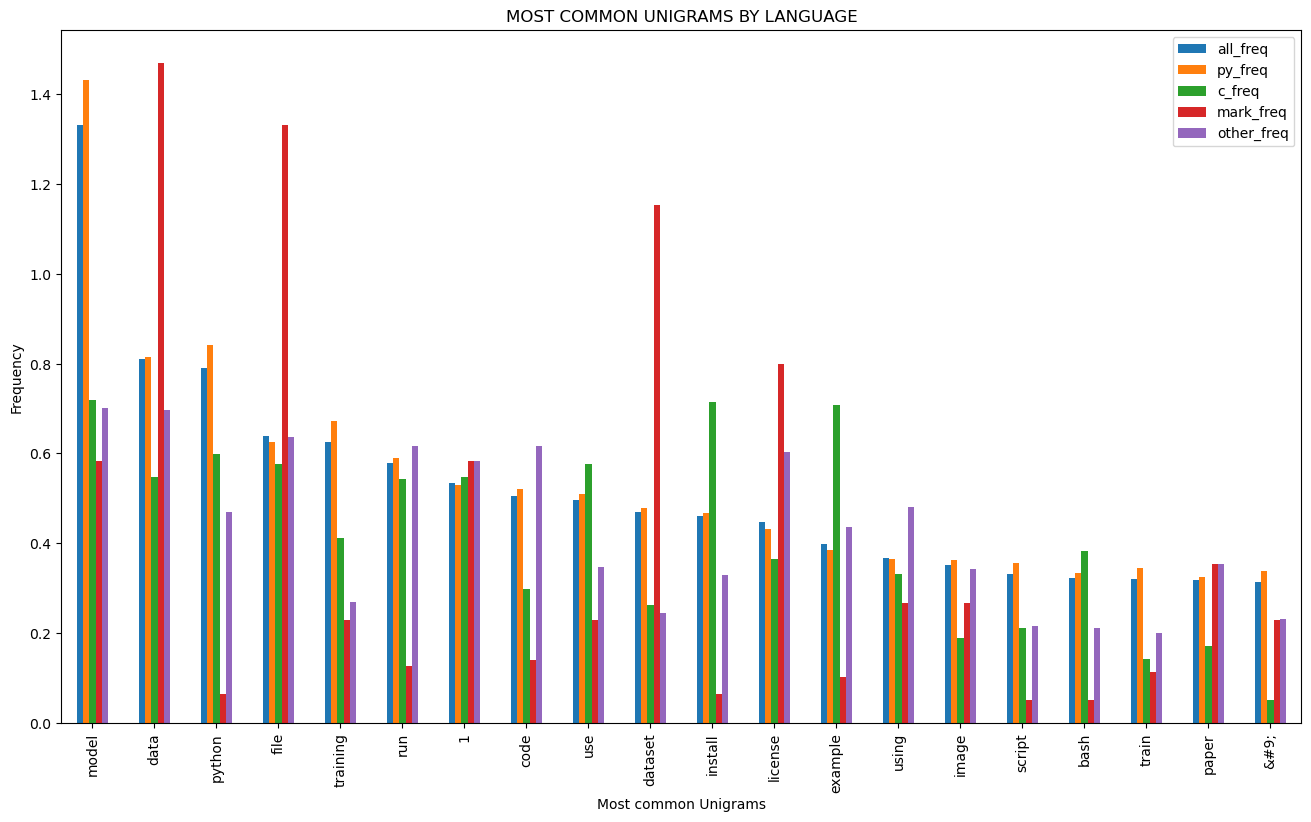

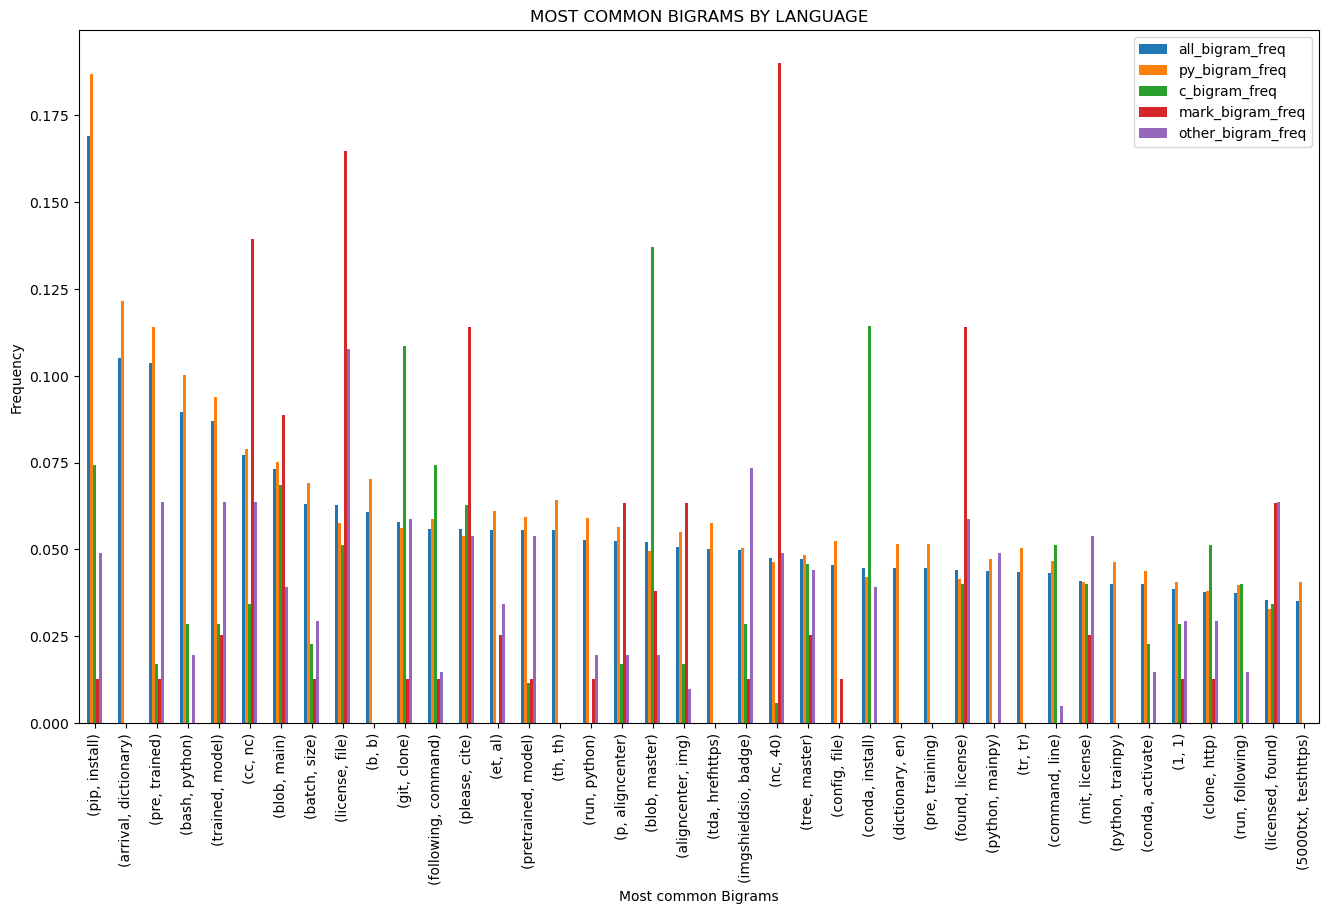

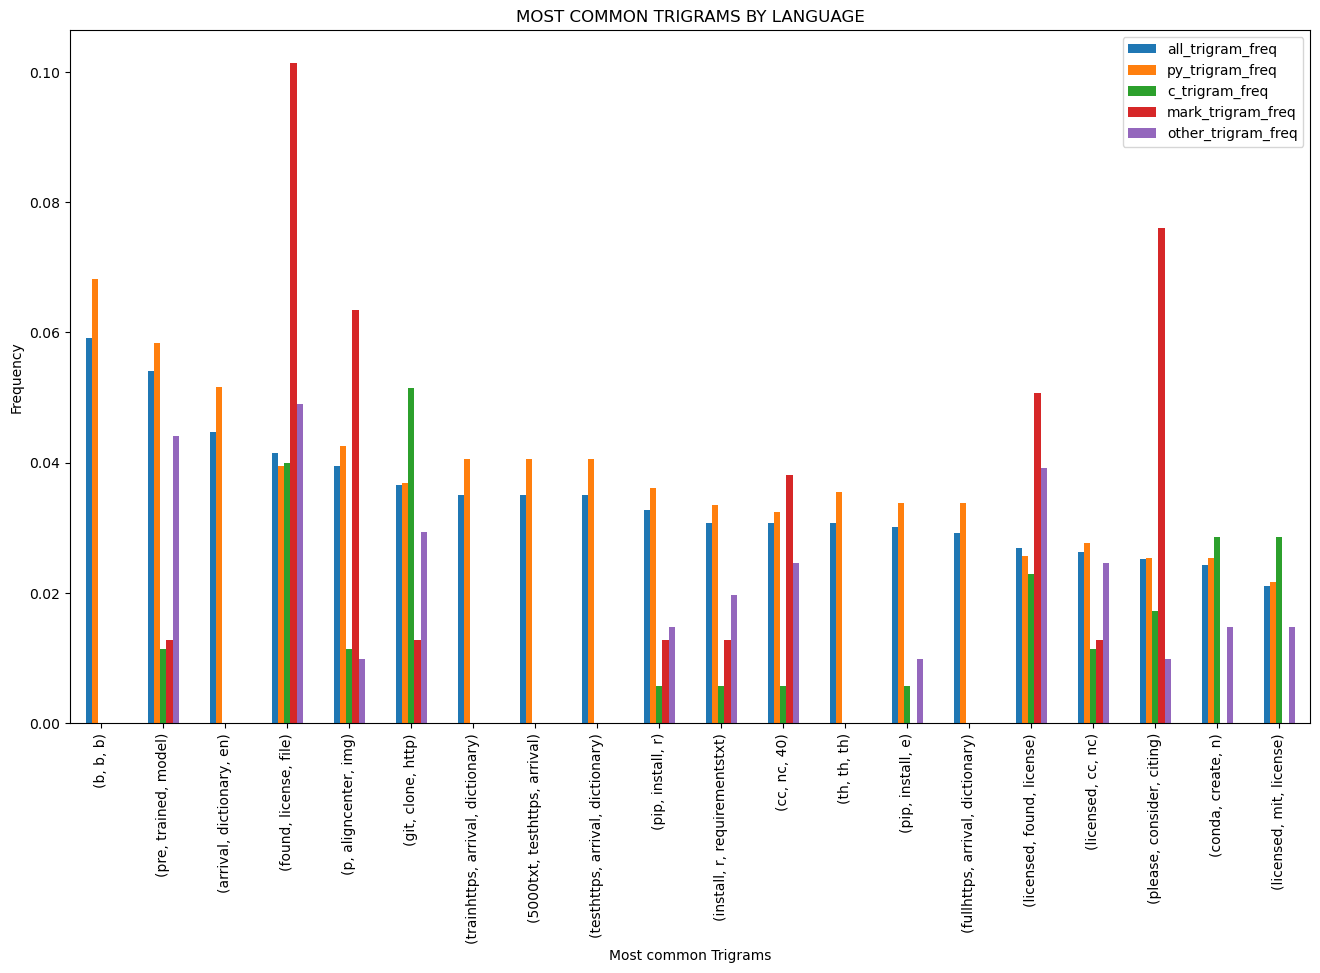

In [820]:
#Plot the most frequent words and color by label
word_freq.sort_values('all_freq', ascending=False).head(20).plot.bar(figsize=(16, 9))
plt.title('MOST COMMON UNIGRAMS BY LANGUAGE')
plt.ylabel('Frequency')
plt.xlabel('Most common Unigrams')
plt.xticks(rotation=90)

# Plot the most frequent bigrams and color by label
bigram_freq.sort_values('all_bigram_freq', ascending=False).head(40).plot.bar(figsize=(16, 9))
plt.title('MOST COMMON BIGRAMS BY LANGUAGE')
plt.ylabel('Frequency')
plt.xlabel('Most common Bigrams')
plt.xticks(rotation=90)

# Plot the most frequent trigrams and color by label
trigram_freq.sort_values('all_trigram_freq', ascending=False).head(20).plot.bar(figsize=(16, 9))
plt.title('MOST COMMON TRIGRAMS BY LANGUAGE')
plt.ylabel('Frequency')
plt.xlabel('Most common Trigrams')
plt.xticks(rotation=90)

plt.show()

In [821]:
bigrams

,,all_bigram_count,py_bigram_count,c_bigram_count,mark_bigram_count,other_bigram_count,all_bigram_freq,py_bigram_freq,c_bigram_freq,mark_bigram_freq,other_bigram_freq
pip,install,578,554,13,1,10,0.168995,0.187031,0.074239,0.012669,0.049003
arrival,dictionary,360,360,0,0,0,0.105257,0.121537,0.000000,0.000000,0.000000
pre,trained,355,338,3,1,13,0.103795,0.114109,0.017132,0.012669,0.063704
bash,python,306,297,5,0,4,0.089468,0.100268,0.028553,0.000000,0.019601
trained,model,298,278,5,2,13,0.087129,0.093853,0.028553,0.025339,0.063704
...,...,...,...,...,...,...,...,...,...,...,...
help,laboverview,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.004900
bwkahqky,gaussian,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.004900
openreviewnet,aepsych,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.004900
tree,stop,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.004900


> Takeaways:
> 
> `UNIGRAMS:` 
- PYTHON - Model, Python; 
- C++ - Install, Example; 
- MARKDOWN Data, File, Dataset; 
- OTHER - Code
> `BIGRAMS:` 
- PYTHON - (pip, install), (arrival, dictionary); 
- C++ - (git, clone), (blob, master), (conda, install); 
- MARKDOWN - (cc, nc), (license, file), (nc, 40), (found, license)
- OTHER - (imgshieldsio, badge); 
> `TRIGRAMS:` 
- PYTHON - (pre, trained, model), (b, b, b); 
- C++ - (git, clone, http); 
- MARKDOWN - (found, licence, file), (please, consider, citing), (p, aligncenter, img); 
- OTHER - (licensed, found, licenced)

<Axes: >

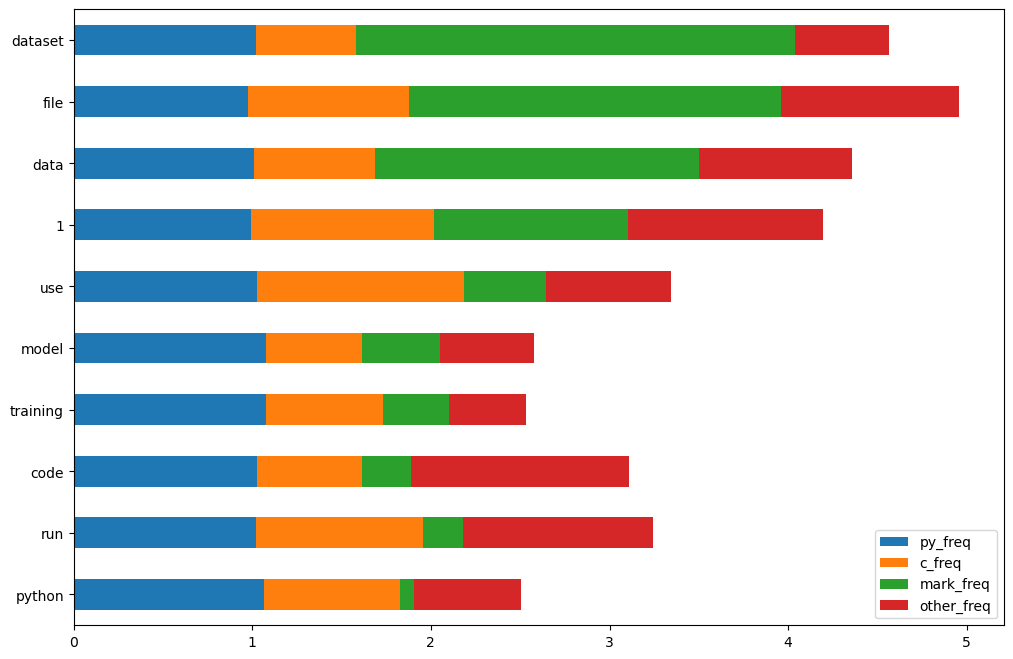

In [822]:
# Visualize language bigrams as percent of all word counts
(word_freq.sort_values(by='all_freq', ascending=False)
    .head(10)
    .apply(lambda row: row / row['all_freq'], axis=1)
    .drop(columns=['all_freq'])
    .sort_values(by='mark_freq')
    .plot.barh(stacked=True, figsize=(12, 8)))

In [823]:
top_20_c_bigrams

(x, x)                    74
(habitat, sim)            37
(blob, master)            24
(conda, install)          20
(git, clone)              19
(master, example)         17
(example, script)         15
(hrefhttps, starspace)    14
(following, command)      13
(pip, install)            13
(use, case)               13
(aria, data)              13
(pytorch, pytorch)        13
(file, format)            13
(starspace, blob)         13
(aria, pilot)             13
(street, address)         12
(blob, main)              12
(project, aria)           12
(replica, dataset)        11
Name: count, dtype: int64

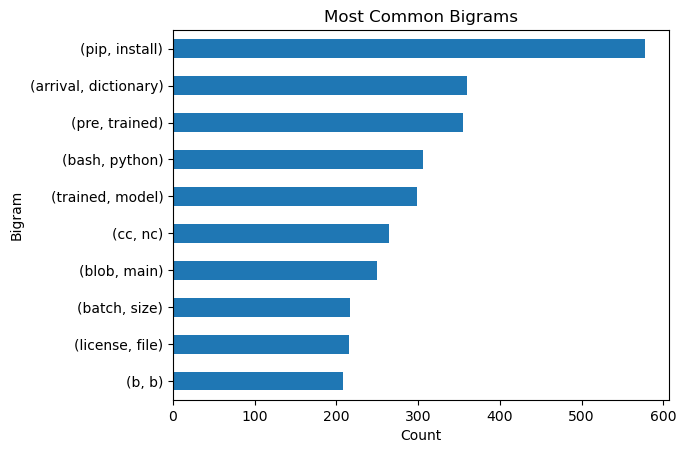

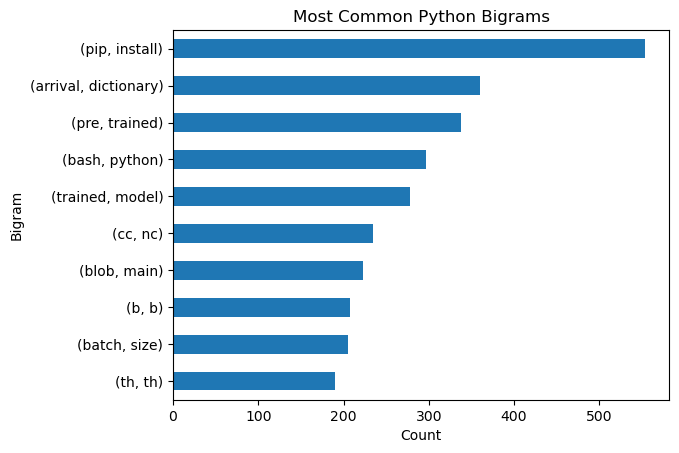

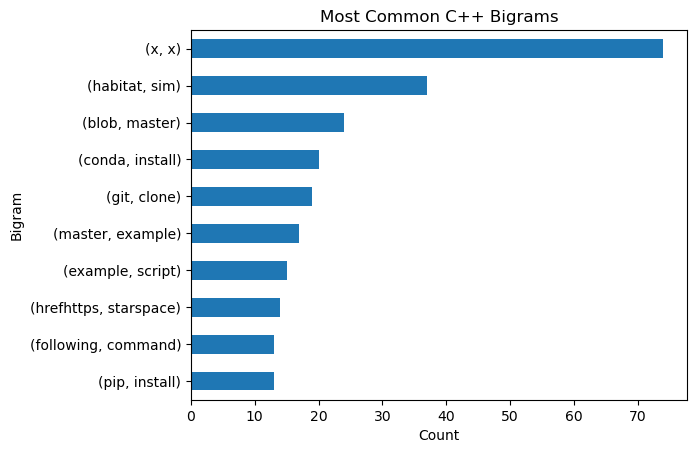

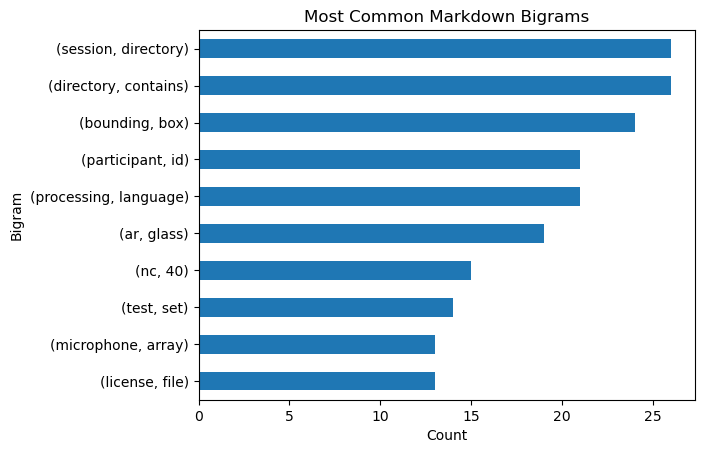

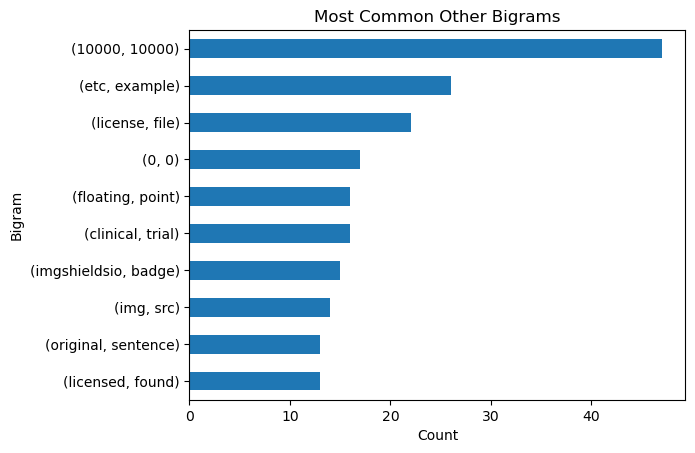

In [824]:
top_20_all_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Bigrams')
plt.show()

top_20_py_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Python Bigrams')
plt.show()

top_20_c_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common C++ Bigrams')
plt.show()

top_20_mark_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Markdown Bigrams')
plt.show()

top_20_other_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Other Bigrams')
plt.show()

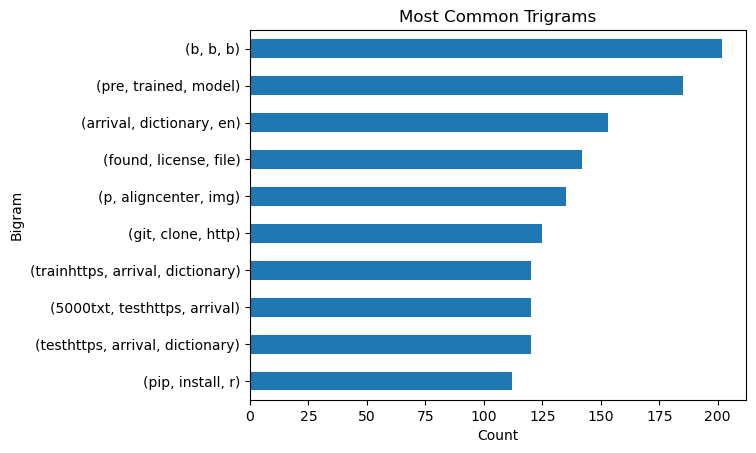

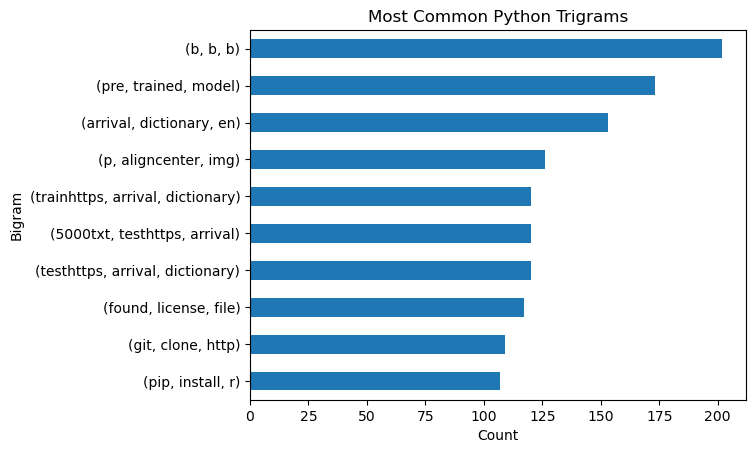

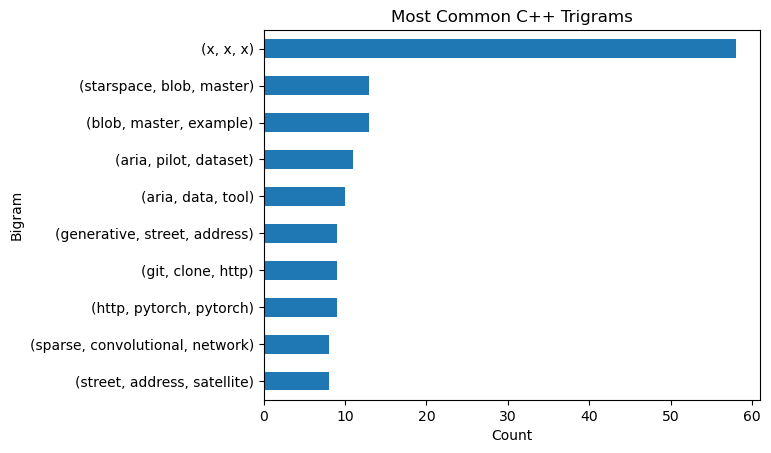

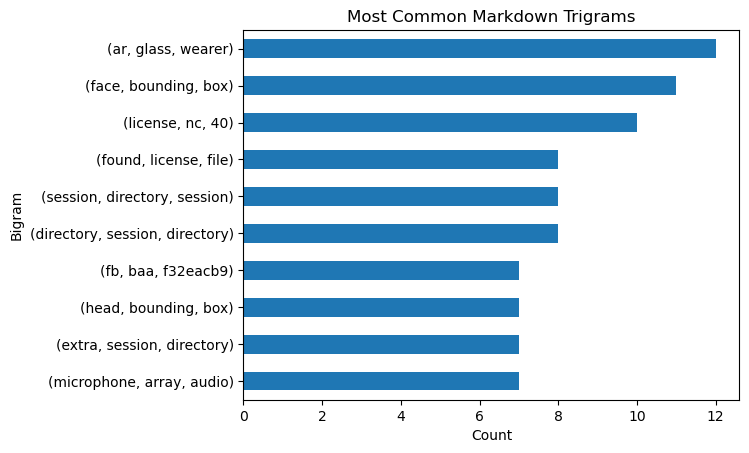

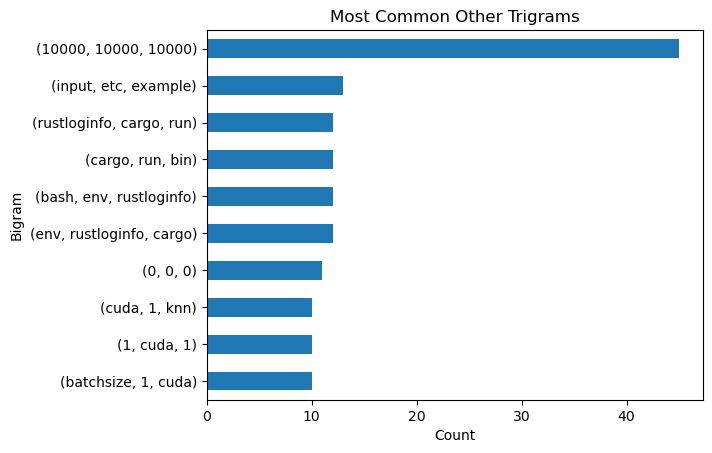

In [825]:
top_20_all_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Trigrams')
plt.show()

top_20_py_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Python Trigrams')
plt.show()

top_20_c_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common C++ Trigrams')
plt.show()

top_20_mark_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Markdown Trigrams')
plt.show()

top_20_other_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Other Trigrams')
plt.show()

### Q1: 

## Modeling

### Baseline:

Baseline Prediction - Python \
Baseline Accuracy - 82.57%

In [826]:
train.language.value_counts(normalize=True)

language
Python      0.825746
Other       0.083203
C++         0.051805
Markdown    0.039246
Name: proportion, dtype: Float64

### Feature Selection:

In [783]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Split the data into training and test sets
train, test = train_test_split(df, train_size=0.7, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

# Define your specific list of unigrams, bigrams, and trigrams as a vocabulary
specific_ngrams = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']

tfidf = TfidfVectorizer(vocabulary=specific_ngrams)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Create and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=666, max_depth=2)
dt.fit(X_train, y_train)

# Make predictions on the training and test data
train_predicted = dt.predict(X_train)
test_predicted = dt.predict(X_test)

# Evaluate the Decision Tree classifier
print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, train_predicted)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, test_predicted)))
print('---')
print('Confusion Matrix')
print(confusion_matrix(y_test, test_predicted))
print('---')
print(classification_report(y_test, test_predicted))

Training Accuracy: 82.76%
Test Accuracy: 82.08%
---
Confusion Matrix
[[  0   0   0   8]
 [  0   5   0   4]
 [  0   1   0  26]
 [  0   4   0 192]]
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         8
    Markdown       0.50      0.56      0.53         9
       Other       0.00      0.00      0.00        27
      Python       0.83      0.98      0.90       196

    accuracy                           0.82       240
   macro avg       0.33      0.38      0.36       240
weighted avg       0.70      0.82      0.76       240



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [784]:
train, test = train_test_split(df, train_size=.8, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

# Define your specific list of n-grams as a vocabulary
specific_ngrams = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']
tfidf = TfidfVectorizer(vocabulary=specific_ngrams)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=1000).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 79.38%
---
Confusion Matrix
actual     C++       Markdown  Other     Python  
predicted                                        
Python            4         8        21       127
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         4
    Markdown       0.00      0.00      0.00         8
       Other       0.00      0.00      0.00        21
      Python       0.79      1.00      0.89       127

    accuracy                           0.79       160
   macro avg       0.20      0.25      0.22       160
weighted avg       0.63      0.79      0.70       160



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
